<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em; font-size: 25px">1. INTRODUCTION</div>

This notebook is to apply Statistical models to predict time series data which include the following:  
1. Moving Average (MA): Simple Moving Average (SMA), Exponentially Weighted Moving Average (EWMA)
2. Holt-Winters Methods: Simple Exponential Smoothing, Double Exponential Smoothing, Triple Exponential Smoothing
3. Autoregressive Model (AR)
4. ARIMA, SARIMA

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em;  font-size: 25px">2. SETUP</div>

In [1]:
import quandl
import warnings
import itertools
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import the models we'll be using in this section
from statsmodels.tsa.stattools import ccovf,ccf
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse, rmse, meanabs

from sklearn.model_selection import TimeSeriesSplit

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Configuration
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 505)

C:\Users\Mai\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em; font-size: 25px">3. DATASET</div>

In [2]:
df = pd.read_csv('Data/airline_passengers.csv', index_col='Month', parse_dates=True)
df.index.freq = 'MS'
print(df.shape)
df.head()

(144, 1)


,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Thousands of Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [4]:
df_bk = df.copy()

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em; font-size: 25px">4. PRELIMINARY ANLYSIS </div>

To explore the dataset:
+ Are there consistent patterns?
+ Is there a significant trend?
+ Is seasonality important?
+ Is there evidence of the presence of business cycles?
+ Are there any outliers in the data that need to be explained by those with expert knowledge?

 ## <font color=red>4.1. Explore time series components</font>

In [5]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

def tsplot(y, lags = None, figsize=(12,8), style = 'bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (2,0))
        pp_ax = plt.subplot2grid(layout, (2,1))
        
        y.plot(ax = ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags = lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags = lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        
        plt.tight_layout()
    
    return

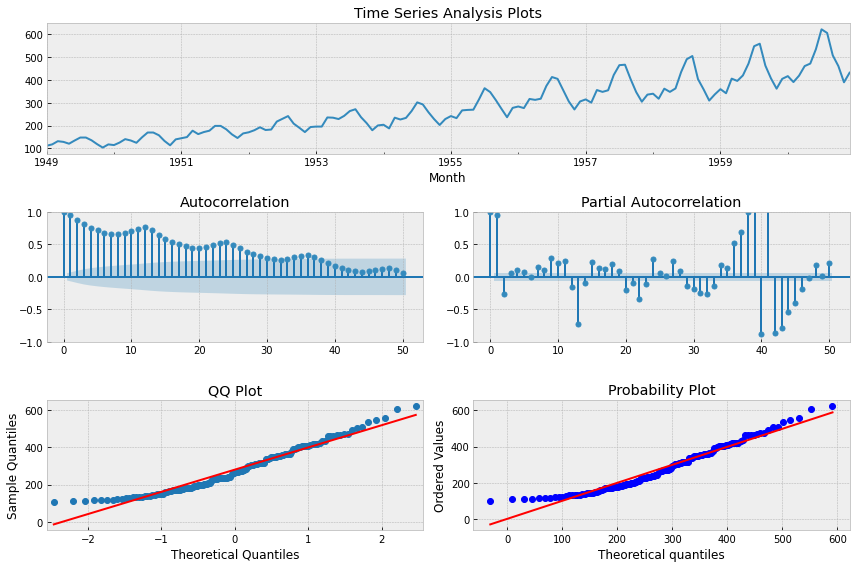

In [6]:
tsplot(df['Thousands of Passengers'], lags=50)

This tells us that the AR component should be more important than MA. From the <a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:<br>
> <em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms.</em><br>

Let's take a look at <tt>pmdarima.auto_arima</tt> done stepwise to see if having $p$ and $q$ terms the same still makes sense:

 ## <font color=red>4.2. Examine stationary</font>

In [7]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
        
from statsmodels.tsa.stattools import adfuller, acf, pacf
def check_stationarity(timeseries, k):
    # Determing rolling statistics
    rolling_mean = timeseries.rolling(window=k, center=False).mean()
    rolling_std = timeseries.rolling(window = k, center = False).std()
        
    # Plot rolling statistics
    plt.figure(figsize=(16,7))
    plt.plot(timeseries.index.to_pydatetime(), timeseries.values, color ='blue', label = 'Original')
    plt.plot(rolling_mean.index.to_pydatetime(), rolling_mean.values, color='red', label='Rolling Mean')
    plt.plot(rolling_std.index.to_pydatetime(), rolling_std.values, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    adf_test(timeseries,title='')

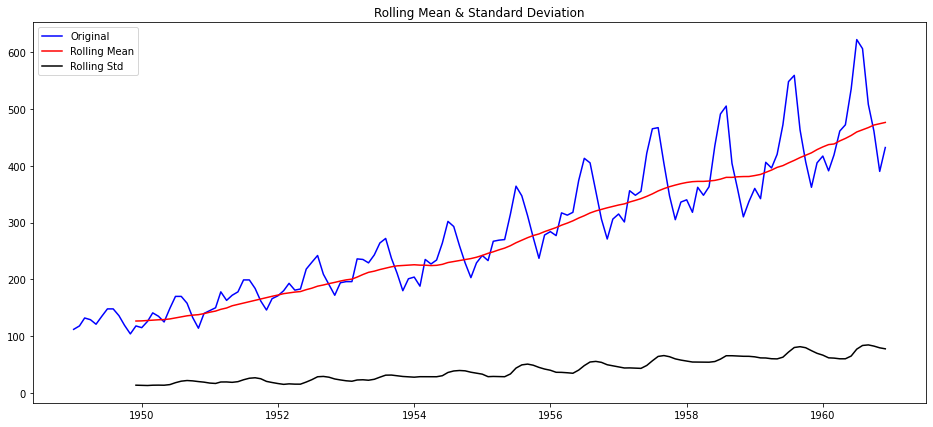

Augmented Dickey-Fuller Test: 
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [8]:
check_stationarity(df['Thousands of Passengers'], 12)

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em;  font-size: 25px">5. MOVING AVERAGE (MA) MODELING</div>

## <font color=RED> 5.1. Simple Moving Average (SMA)

### <font color=blue>1. Introduction</font>     
Is a linear regression model that models the impact of noise/error from prior observations to current one. The model is denoted as

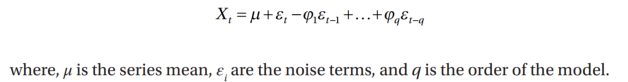

1. We can calcullate SMA by applying a <tt>mean</tt> function to a rolling window.
    + If we use a longer window size, we grab the general trend
    + If we choose a shorter window size, we can then grab the kind of more detailed behavior of that time series, so it can grab a little bit of that seasonality, such as the orange line for a six month simple moving average
    
2. We could theoretically attempt to use these simple moving averages to build a generalized model for the real world time series we’re analyzing. Just think of it as trying to create a generalized model to describe the general behavior of your time series

### <font color=blue>2. Apply to Data</font> 

In [9]:
df['6-month-SMA'] = df['Thousands of Passengers'].rolling(window=6).mean()
df['12-month-SMA'] = df['Thousands of Passengers'].rolling(window=12).mean()

df.head(15)

,Thousands of Passengers,6-month-SMA,12-month-SMA
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN
1949-06-01,135,124.500000,NaN
1949-07-01,148,130.500000,NaN
1949-08-01,148,135.500000,NaN
1949-09-01,136,136.166667,NaN


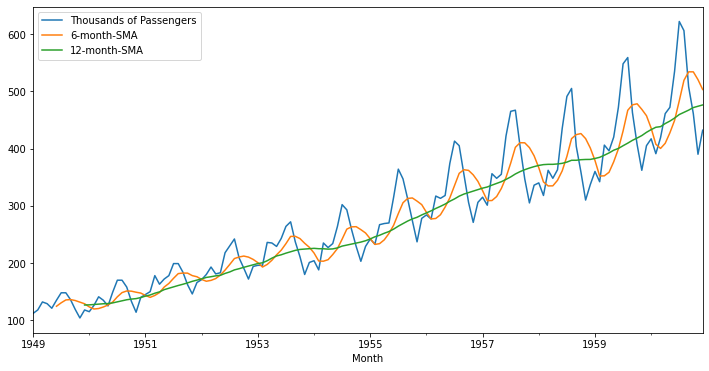

In [10]:
df.plot(figsize=(12,6));

+ Simple moving averages can allow to describe some trend value behavior of a time series. As issue with SMA is that the entire model will be constrained to the same window size. For example, we choose 6-month window size or 12-month window size. We have to use that window for the entire dataset, even if it’s much longer than just 12 months.

+ Smaller windows will lead to more noise, rather than signal. So it’s hard to balance the window size because as you go smaller, you are being more accurate as far as what you’re able to model from that generalized time series. But you start picking up more and more noise. 

+ With SMA, you’re always going to lag by the size of the window. So, it will never reach to full peak or valley of the data due to the averaging. It’s hard to choose a window size that is going to fill up those peaks and valleys for seasonal data, even if you choose very small windows.

+ Does not really inform you about possible future behavior, all it really does is describe trends in your data. 


## <font color=RED> 5.2. Exponentially Weighted Moving Average (EWMA)

### <font color=blue>1. Introduction</font>     
To help fix some of these issues, we can use an <a href='https://en.wikipedia.org/wiki/Exponential_smoothing'>EWMA (Exponentially weighted moving average)</a>.

EWMA will allow us to reduce the lag effect from SMA and it will put more weight on values that occured more recently (by applying more weight to the more recent values, thus the name). The amount of weight applied to the most recent values will depend on the actual parameters used in the EWMA and the number of periods given a window size.
[Full details on Mathematics behind this can be found here](http://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows).
Here is the shorter version of the explanation behind EWMA.

The formula for EWMA is:
### $y_t =   \frac{\sum\limits_{i=0}^t w_i x_{t-i}}{\sum\limits_{i=0}^t w_i}$

Where $x_t$ is the input value, $w_i$ is the applied weight (Note how it can change from $i=0$ to $t$), and $y_t$ is the output.

Now the question is, how to we define the weight term $w_i$?

This depends on the <tt>adjust</tt> parameter you provide to the <tt>.ewm()</tt> method.

When <tt>adjust=True</tt> (default) is used, weighted averages are calculated using weights equal to $w_i = (1 - \alpha)^i$

which gives

### $y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^t}$

When <tt>adjust=False</tt> is specified, moving averages are calculated as:

### $\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

which is equivalent to using weights:

 \begin{split}w_i = \begin{cases}
    \alpha (1 - \alpha)^i & \text{if } i < t \\
    (1 - \alpha)^i        & \text{if } i = t.
\end{cases}\end{split}

When <tt>adjust=True</tt> we have $y_0=x_0$ and from the last representation above we have 
$y_t=\alpha x_t+(1−α)y_{t−1}$, therefore there is an assumption that $x_0$ is not an ordinary value but rather an exponentially weighted moment of the infinite series up to that point.

For the smoothing factor $\alpha$ one must have $0<\alpha≤1$, and while it is possible to pass <em>alpha</em> directly, it’s often easier to think about either the <em>span</em>, <em>center of mass</em> (com) or <em>half-life</em> of an EW moment:

\begin{split}\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{for span}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{for center of mass}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{for half-life}\ h > 0
 \end{cases}\end{split}

* <strong>Span</strong> corresponds to what is commonly called an “N-day EW moving average”.
* <strong>Center of mass</strong> has a more physical interpretation and can be thought of in terms of span: $c=(s−1)/2$
* <strong>Half-life</strong> is the period of time for the exponential weight to reduce to one half.
* <strong>Alpha</strong> specifies the smoothing factor directly.

We have to pass precisely one of the above into the <tt>.ewm()</tt> function. For our data we'll use <tt>span=12</tt>.

### <font color=blue>2. Apply to Data</font> 

In [11]:
df['EWMA12'] = df['Thousands of Passengers'].ewm(span=12,adjust=False).mean()

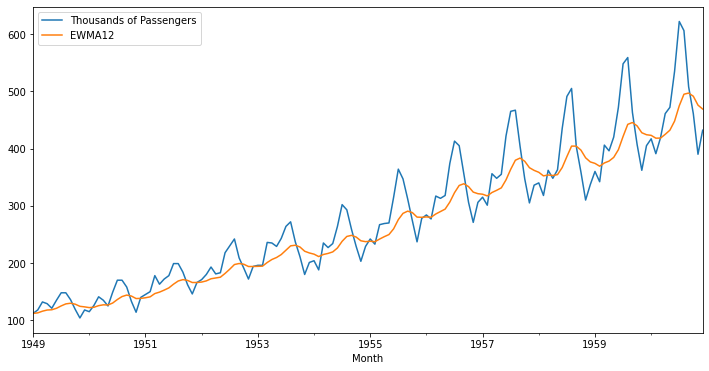

In [12]:
df[['Thousands of Passengers','EWMA12']].plot(figsize=(12,6));

 ### <font color=blue> 3. Comparing SMA to EWMA

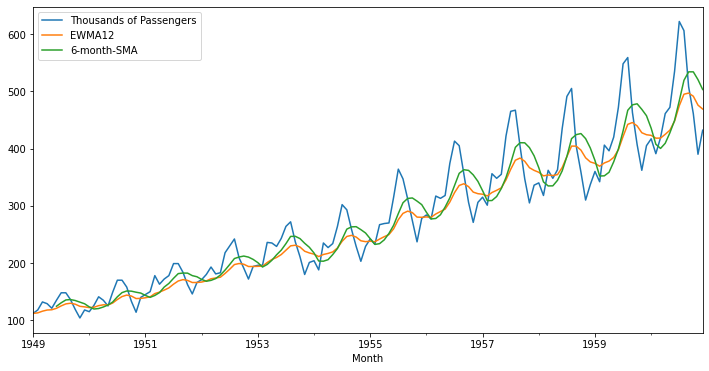

In [13]:
df[['Thousands of Passengers','EWMA12','6-month-SMA']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

**EWMA** and **SMA** using just one smoothing factor $\alpha$ (alpha). This failed to account for other contributing factors like trend and seasonality

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em;  font-size: 25px">6. HOLT-WINTERS METHODS</div>

 ## <font color=red> 6.1. Introduction
    
**This method is used for moving average model, we forcast the variable of interest using a linear combination of predictors which are based on level, trend and seasonal predictors**
    
In this section we'll look at <em>Double</em> and <em>Triple Exponential Smoothing</em> with the <a href='https://otexts.com/fpp2/holt-winters.html'>Holt-Winters Methods</a>. 

In <strong>Double Exponential Smoothing</strong> (aka Holt's Method) we introduce a new smoothing factor $\beta$ (beta) that addresses trend:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
y_t &= l_t + b_t & \text{    fitted model}\\
\hat y_{t+h} &= l_t + hb_t & \text{    forecasting model (} h = \text{# periods into the future)}\end{split}

Because we haven't yet considered seasonal fluctuations, the forecasting model is simply a straight sloped line extending from the most recent data point. We'll see an example of this in upcoming lectures.

With <strong>Triple Exponential Smoothing</strong> (aka the Holt-Winters Method) we introduce a smoothing factor $\gamma$ (gamma) that addresses seasonality:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
c_t &= (1-\gamma)c_{t-L} + \gamma(x_t-l_{t-1}-b_{t-1}) & \text{    seasonal}\\
y_t &= (l_t + b_t) c_t & \text{    fitted model}\\
\hat y_{t+m} &= (l_t + mb_t)c_{t-L+1+(m-1)modL} & \text{    forecasting model (} m = \text{# periods into the future)}\end{split}

Here $L$ represents the number of divisions per cycle. In our case looking at monthly data that displays a repeating pattern each year, we would use $L=12$.

In general, higher values for $\alpha$, $\beta$ and $\gamma$ (values closer to 1), place more emphasis on recent data.


 ## <font color=red> 6.2. Simple Exponential Smoothing

A variation of the statmodels Holt-Winters function provides Simple Exponential Smoothing. We'll show that it performs the same calculation of the weighted moving average as the pandas <tt>.ewm()</tt> method:<br>
$\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12
alpha = 2/(span+1)

df['EWMA12'] = df['Thousands of Passengers'].ewm(alpha=alpha,adjust=False).mean()
df['SES12']=SimpleExpSmoothing(df['Thousands of Passengers']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,6-month-SMA,12-month-SMA,EWMA12,SES12
Month,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000
1949-02-01,118,NaN,NaN,112.923077,112.923077
1949-03-01,132,NaN,NaN,115.857988,115.857988
1949-04-01,129,NaN,NaN,117.879836,117.879836
1949-05-01,121,NaN,NaN,118.359861,118.359861


<div class="alert alert-danger"><strong>NOTE:</strong> For some reason, when <tt>optimized=False</tt> is passed into <tt>.fit()</tt>, the statsmodels <tt>SimpleExpSmoothing</tt> function shifts fitted values down one row. We fix this by adding <tt>.shift(-1)</tt> after <tt>.fittedvalues</tt></div>

## <font color=red>6.3. Double Exponential Smoothing
Where Simple Exponential Smoothing employs just one smoothing factor $\alpha$ (alpha), Double Exponential Smoothing adds a second smoothing factor $\beta$ (beta) that addresses trends in the data. Like the alpha factor, values for the beta factor fall between zero and one ($0<\beta≤1$). The benefit here is that the model can anticipate future increases or decreases where the level model would only work from recent calculations.

We can also address different types of change (growth/decay) in the trend. If a time series displays a straight-line sloped trend, you would use an <strong>additive</strong> adjustment. If the time series displays an exponential (curved) trend, you would use a <strong>multiplicative</strong> adjustment.

As we move toward forecasting, it's worth noting that both additive and multiplicative adjustments may become exaggerated over time, and require <em>damping</em> that reduces the size of the trend over future periods until it reaches a flat line.

In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df['DESadd12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='add').fit().fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,6-month-SMA,12-month-SMA,EWMA12,SES12,DESadd12
Month,,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000,114.102394
1949-02-01,118,NaN,NaN,112.923077,112.923077,120.040657
1949-03-01,132,NaN,NaN,115.857988,115.857988,134.001539
1949-04-01,129,NaN,NaN,117.879836,117.879836,131.085845
1949-05-01,121,NaN,NaN,118.359861,118.359861,123.110263


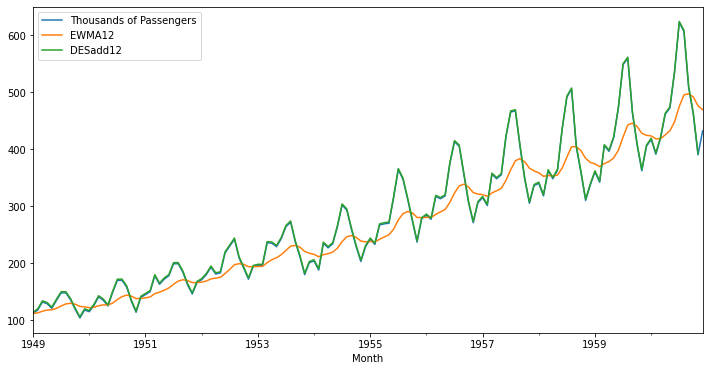

In [16]:
df[['Thousands of Passengers','EWMA12','DESadd12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

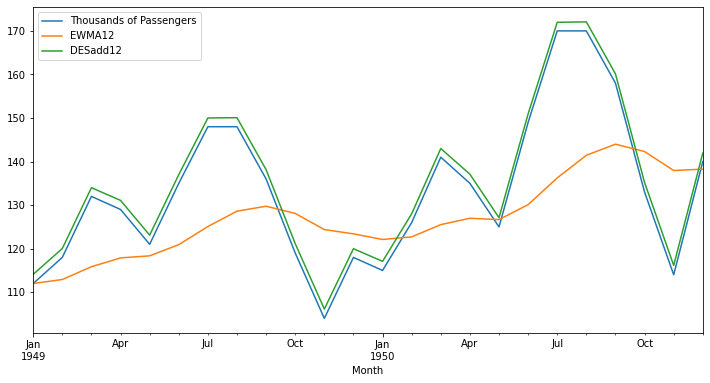

In [17]:
df[['Thousands of Passengers','EWMA12','DESadd12']].iloc[0:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Here we can see that Double Exponential Smoothing is a much better representation of the time series data.<br>
Let's see if using a multiplicative seasonal adjustment helps.

In [18]:
df['DESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='mul').fit().fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,6-month-SMA,12-month-SMA,EWMA12,SES12,DESadd12,DESmul12
Month,,,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000,114.102394,113.990701
1949-02-01,118,NaN,NaN,112.923077,112.923077,120.040657,120.031669
1949-03-01,132,NaN,NaN,115.857988,115.857988,134.001539,134.235979
1949-04-01,129,NaN,NaN,117.879836,117.879836,131.085845,131.270786
1949-05-01,121,NaN,NaN,118.359861,118.359861,123.110263,123.156267


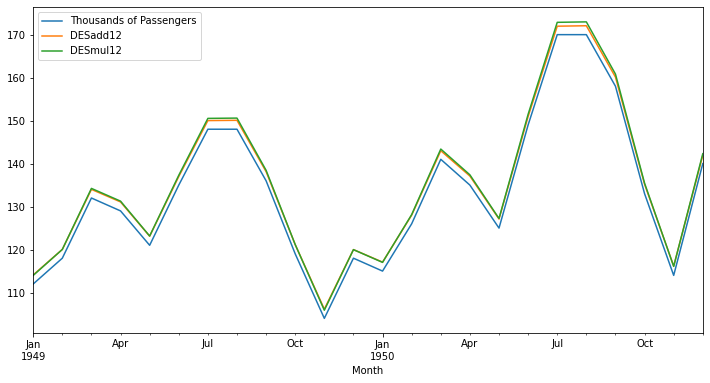

In [19]:
df[['Thousands of Passengers','DESadd12','DESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Although minor, it does appear that a multiplicative adjustment gives better results. Note that the green line almost completely overlaps the original data.

 ## <font color=red>6.4. Triple Exponential Smoothing
Triple Exponential Smoothing, the method most closely associated with Holt-Winters, adds support for both trends and seasonality in the data. 



In [20]:
df['TESadd12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df.head()

,Thousands of Passengers,6-month-SMA,12-month-SMA,EWMA12,SES12,DESadd12,DESmul12,TESadd12
Month,,,,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000,114.102394,113.990701,112.006984
1949-02-01,118,NaN,NaN,112.923077,112.923077,120.040657,120.031669,120.149251
1949-03-01,132,NaN,NaN,115.857988,115.857988,134.001539,134.235979,134.693302
1949-04-01,129,NaN,NaN,117.879836,117.879836,131.085845,131.270786,131.367738
1949-05-01,121,NaN,NaN,118.359861,118.359861,123.110263,123.156267,124.625107


In [21]:
df['TESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df.head()

,Thousands of Passengers,6-month-SMA,12-month-SMA,EWMA12,SES12,DESadd12,DESmul12,TESadd12,TESmul12
Month,,,,,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000,114.102394,113.990701,112.006984,111.592072
1949-02-01,118,NaN,NaN,112.923077,112.923077,120.040657,120.031669,120.149251,118.842954
1949-03-01,132,NaN,NaN,115.857988,115.857988,134.001539,134.235979,134.693302,133.333217
1949-04-01,129,NaN,NaN,117.879836,117.879836,131.085845,131.270786,131.367738,127.901748
1949-05-01,121,NaN,NaN,118.359861,118.359861,123.110263,123.156267,124.625107,120.980377


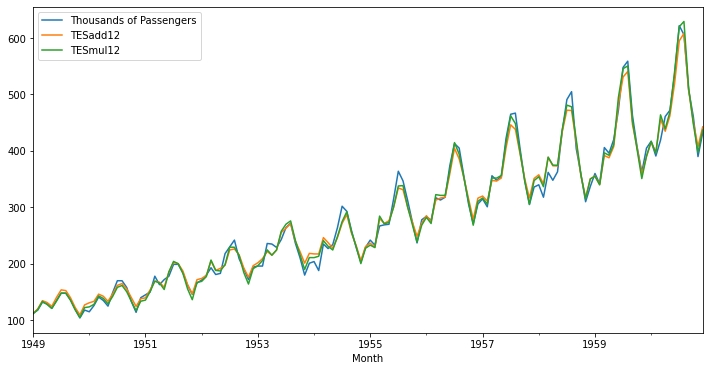

In [22]:
df[['Thousands of Passengers','TESadd12','TESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

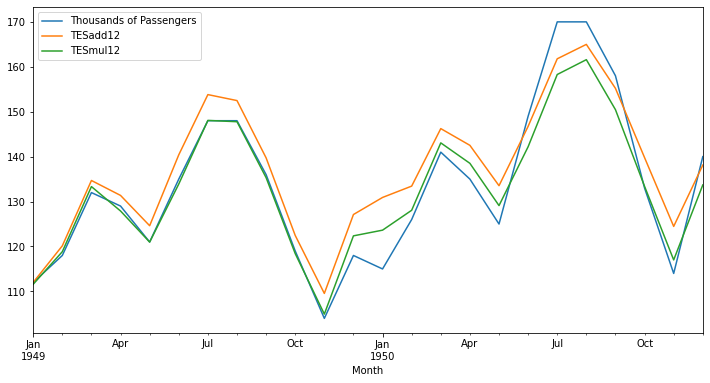

In [23]:
df[['Thousands of Passengers','TESadd12','TESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Based on the plot above, you might think that Triple Exponential Smoothing does a poorer job of fitting than Double Exponential Smoothing. The key here is to consider what comes next - <em>forecasting</em>. We'll see that having the ability to predict fluctuating seasonal patterns greatly improves our forecast.

But first, we'll work out some time series exercises before moving on to forecasting.

 ## <font color=red>6.5. Forecasting with the Holt-Winters Method
Triple Exponential Smoothing, the method most closely associated with Holt-Winters, adds support for both trends and seasonality in the data. 

In [24]:
df = df_bk.copy()

### <font color=blue> 1. Train Test Split

In [25]:
train_data = df.iloc[:108] # Goes up to but not including 108
test_data = df.iloc[108:]

### <font color=blue> 2. Fit the model

In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model = ExponentialSmoothing(train_data['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

### <font color=blue> 3. Evaluating Model against Test Set

In [27]:
# YOU CAN SAFELY IGNORE WARNINGS HERE!
# THIS WILL NOT AFFECT YOUR FORECAST, IT'S JUST SOMETHING STATSMODELS NEEDS TO UPDATE UPON NEXT RELEASE.
test_predictions = fitted_model.forecast(36).rename('HW Forecast')

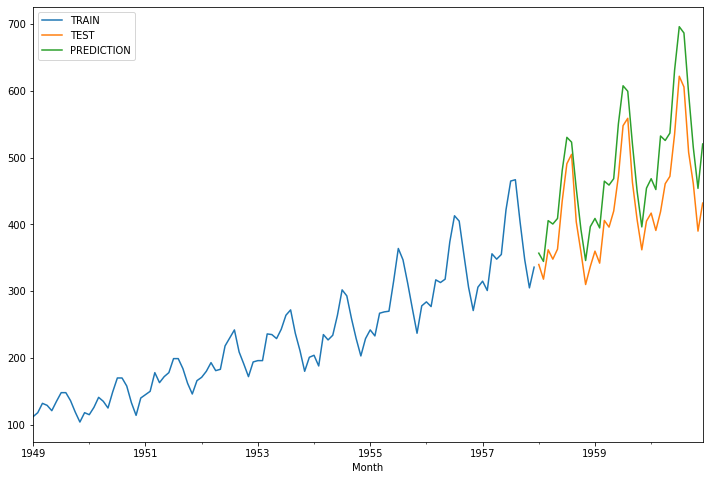

In [28]:
train_data['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_data['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION');

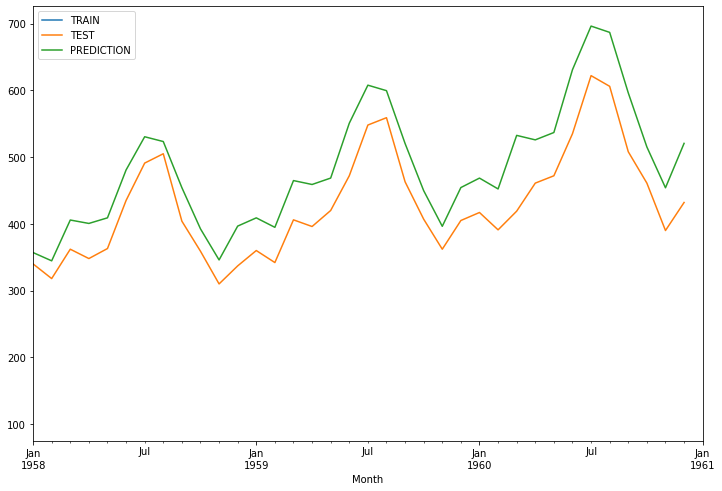

In [29]:
train_data['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_data['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION',xlim=['1958-01-01','1961-01-01']);

### <font color=blue> 4. Evaluation Metrics

In [30]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [31]:
mean_absolute_error(test_data,test_predictions)

55.69782636118518

In [32]:
mean_squared_error(test_data,test_predictions)

3525.867525316523

In [33]:
np.sqrt(mean_squared_error(test_data,test_predictions))

59.37901586685757

In [34]:
test_data.describe()

,Thousands of Passengers
count,36.000000
mean,428.500000
std,79.329152
min,310.000000
25%,362.000000
50%,412.000000
75%,472.000000
max,622.000000


### <font color=blue> 5. Forecasting into Future

In [35]:
final_model = ExponentialSmoothing(df['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

In [36]:
forecast_predictions = final_model.forecast(36)

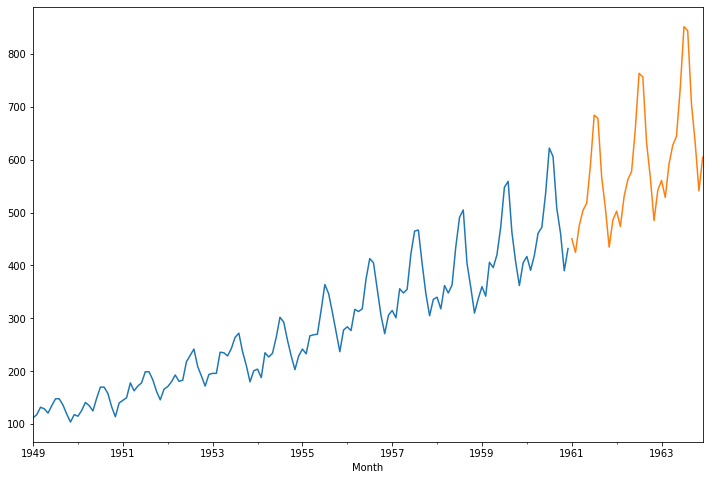

In [37]:
df['Thousands of Passengers'].plot(figsize=(12,8))
forecast_predictions.plot();

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em;  font-size: 25px">7. AUTOREGRESSIVE MODEL (AR) </div>


 ## <font color=RED> 7.1. Introduction
In an autoregression model, we forecast using a linear combination of <em>past values</em> of the variable. The term <em>autoregression</em> describes a regression of the variable against itself. An autoregression is run against a set of <em>lagged values</em> of order $p$.

### $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$

where $c$ is a constant, $\phi_{1}$ and $\phi_{2}$ are lag coefficients up to order $p$, and $\varepsilon_{t}$ is white noise.

For example, an <strong>AR(1)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

whereas an <strong>AR(2)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \varepsilon_{t}$

and so on.

Note that the lag coeffients are usually less than one, as we usually restrict autoregressive models to stationary data.<br>
Specifically, for an <strong>AR(1)</strong> model: $-1 \lt \phi_1 \lt 1$<br>
and for an <strong>AR(2)</strong> model: $-1 \lt \phi_2 \lt 1, \ \phi_1 + \phi_2 \lt 1, \ \phi_2 - \phi_1 \lt 1$<br>

Models <strong>AR(3)</strong> and higher become mathematically very complex. Fortunately statsmodels does all the heavy lifting for us.

 ## <font color=RED> 7.2. Fit AR(1) Model

### <font color=blue> 1. Split the data into train/test sets
The goal in this section is to:
* Split known data into a training set of records on which to fit the model
* Use the remaining records for testing, to evaluate the model
* Fit the model again on the <em>full</em> set of records
* Predict a future set of values using the model

As a general rule you should set the length of your test set equal to your intended forecast size. That is, for a monthly dataset you might want to forecast out one more year. Therefore your test set should be one year long.

In [38]:
print(len(df))

# Set one year for testing
train = df.iloc[:120]
test = df.iloc[120:]

144


 ### <font color=blue> 2. Train model

In [39]:
# Load specific forecasting tools
from statsmodels.tsa.ar_model import AutoReg,ARResults

model = AutoReg(train['Thousands of Passengers'], lags=1)
AR1fit = model.fit()
print(f'Coefficients:\n{AR1fit.params}')

Coefficients:
const                         14.264267
Thousands of Passengers.L1     0.949525
dtype: float64


### <font color=blue> 3. Prediction

In [40]:
# This is the general format for obtaining predictions
start=len(train)
end=len(train)+len(test)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')
predictions1

1959-01-01    334.254295
1959-02-01    331.647179
1959-03-01    329.171656
1959-04-01    326.821085
1959-05-01    324.589158
1959-06-01    322.469887
1959-07-01    320.457585
1959-08-01    318.546853
1959-09-01    316.732566
1959-10-01    315.009853
1959-11-01    313.374095
1959-12-01    311.820900
1960-01-01    310.346103
1960-02-01    308.945745
1960-03-01    307.616070
1960-04-01    306.353511
1960-05-01    305.154678
1960-06-01    304.016356
1960-07-01    302.935491
1960-08-01    301.909182
1960-09-01    300.934675
1960-10-01    300.009357
1960-11-01    299.130743
1960-12-01    298.296478
Freq: MS, Name: AR(1) Predictions, dtype: float64

In [41]:
# Comparing predictions to expected values
for i in range(len(predictions1)):
    print(f"predicted={predictions1[i]}, expected={test['Thousands of Passengers'][i]}")

predicted=334.25429528565525, expected=360
predicted=331.647179171782, expected=342
predicted=329.1716564414219, expected=406
predicted=326.8210849590396, expected=396
predicted=324.589157848847, expected=420
predicted=322.4698865726703, expected=472
predicted=320.45758486195723, expected=548
predicted=318.54685346081067, expected=559
predicted=316.73256563911326, expected=463
predicted=315.0098534368727, expected=407
predicted=313.374094602879, expected=362
predicted=311.8209001926297, expected=405
predicted=310.34610279224535, expected=417
predicted=308.9457453367795, expected=391
predicted=307.61607049292115, expected=419
predicted=306.3535105776018, expected=461
predicted=305.15467798545797, expected=472
predicted=304.0163560994643, expected=535
predicted=302.93549066034996, expected=622
predicted=301.9091815716408, expected=606
predicted=300.9346751183396, expected=508
predicted=300.00935657836646, expected=461
predicted=299.1307432069336, expected=390
predicted=298.29647757503227

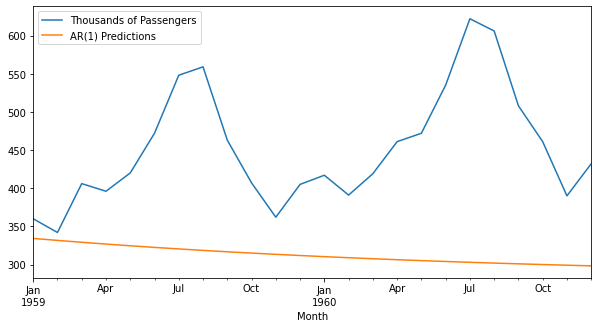

In [42]:
test['Thousands of Passengers'].plot(legend=True)
predictions1.plot(legend=True,figsize=(10,5));

 ## <font color=RED> 7.2. Fit AR(2) Model

In [43]:
model = AutoReg(train['Thousands of Passengers'], lags=2)
AR2fit = model.fit()
print(f'Coefficients"\n{AR2fit.params}')

Coefficients"
const                         16.913669
Thousands of Passengers.L1     1.249260
Thousands of Passengers.L2    -0.312533
dtype: float64


In [44]:
start=len(train)
end=len(train)+len(test)-1
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')

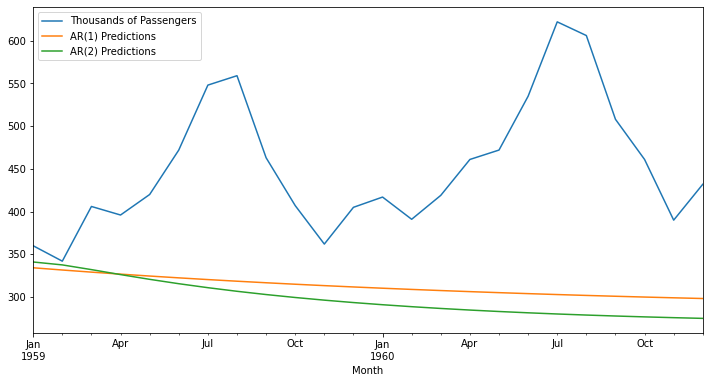

In [45]:
test['Thousands of Passengers'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

## <font color=red> 7.4. Fit an AR(p) Model where statsmodels chooses p


### <font color=blue> 1. Train Model

In [46]:
model = AutoReg(train['Thousands of Passengers'],lags=12)
ARfit = model.fit()
print(f'Coefficients:\n{ARfit.params}')

Coefficients:
const                          13.805113
Thousands of Passengers.L1      0.509977
Thousands of Passengers.L2     -0.297314
Thousands of Passengers.L3      0.225846
Thousands of Passengers.L4     -0.293591
Thousands of Passengers.L5      0.322945
Thousands of Passengers.L6     -0.278616
Thousands of Passengers.L7      0.274691
Thousands of Passengers.L8     -0.360098
Thousands of Passengers.L9      0.299016
Thousands of Passengers.L10    -0.278999
Thousands of Passengers.L11     0.368750
Thousands of Passengers.L12     0.533608
dtype: float64


In [47]:
start = len(train)
end = len(train)+len(test)-1
rename = f'AR(12) Predictions'

predictions12 = ARfit.predict(start=start,end=end,dynamic=False).rename(rename)

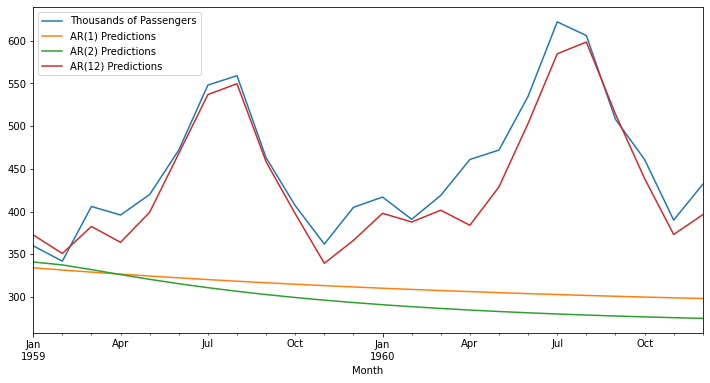

In [48]:
test['Thousands of Passengers'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions12.plot(legend=True,figsize=(12,6));

### <font color=blue> 2. Evaluate the Model
    
It helps to have a means of comparison between two or more models. One common method is to compute the Mean Squared Error (MSE), available from scikit-learn.

In [49]:
from sklearn.metrics import mean_squared_error

labels = ['AR(1)','AR(2)','AR(12)']
preds = [predictions1, predictions2, predictions12]  # these are variables, not strings!

for i in range(3):
    error = mean_squared_error(test['Thousands of Passengers'], preds[i])
    print(f'{labels[i]} Error: {error:11.10}')

AR(1) Error: 25759.96727
AR(2) Error: 30911.62376
AR(12) Error: 732.9665004


We see right away how well AR(11) outperformed the other two models.

Another method is the <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'>Akaike information criterion</a> (AIC), which does a better job of evaluating models by avoiding overfitting.<br>
Fortunately this is available directly from the fit model object.

In [50]:
modls = [AR1fit,AR2fit,ARfit]

for i in range(3):
    print(f'{labels[i]} AIC: {modls[i].aic:6.5}')

AR(1) AIC: 1138.9
AR(2) AIC: 1120.2
AR(12) AIC: 886.25


### <font color=blue> 6. Forecasting

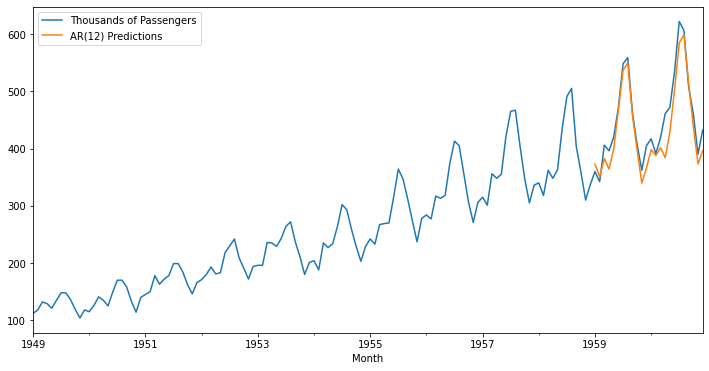

In [51]:
# Forcast
fc = ARfit.predict(start=start,end=end,dynamic=False).rename(rename)

# Plot the results
df['Thousands of Passengers'].plot(legend=True)
fc.plot(legend=True,figsize=(12,6));

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em;  font-size: 25px">8. ARIMA </div>

## <font color=red> 8.1. ARIMA
    
### <font color=blue>1. Introduction</font>    
    
<strong>ARIMA</strong>, or <em>Autoregressive Integrated Moving Average</em> is actually a combination of AR model and MA model with a differenced series:
* <strong>AR(p)</strong> Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period. It is the correlation a current time series with a lagged version of the same series.

    
* <strong>I(d)</strong> Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary. We apply differencing to make a time series stationary, which ARIMA requires.

    
* <strong>MA(q)</strong> Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. Can be found using SMA, EWMA or Holt-Winters Method
    
Thus, for a stationary time series ARIMA models combine autoregression and moving average concepts to model the behavior of a long running time series and helps in forecasting.

**Example**:
Recall that an <strong>AR(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant, $\mu$ is the expectation of $y_{t}$ (often assumed to be zero), $\phi_1$ (phi-sub-one) is the AR lag coefficient, $\theta_1$ (theta-sub-one) is the MA lag coefficient, and $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(1,1)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

ARMA models can be used on stationary datasets.

For non-stationary datasets with a trend component, ARIMA models apply a differencing coefficient as well.

Once we understand the components, we'll investigate how to best choose the $p$, $d$ and $q$ values required by the model.

### <font color=blue> 2. Split data

In [52]:
ts_data = df['Thousands of Passengers']
# split data into 2 sets: train set and test set
size = int(len(ts_data) - 25)
train, test = ts_data[0:size], ts_data[size:len(ts_data.values)]

### <font color=blue> 3. Train the model

In [53]:
model = sm.tsa.ARIMA(train, order=(12,2,1))
results_ARIMA = model.fit()

### <font color=blue>4. Print the results of the ARIMA model

In [54]:
print(results_ARIMA.summary())

                                  SARIMAX Results                                  
Dep. Variable:     Thousands of Passengers   No. Observations:                  119
Model:                     ARIMA(12, 2, 1)   Log Likelihood                -447.296
Date:                     Sat, 12 Apr 2025   AIC                            922.592
Time:                             17:09:21   BIC                            961.263
Sample:                         01-01-1949   HQIC                           938.292
                              - 11-01-1958                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1305      0.104     -1.253      0.210      -0.335       0.074
ar.L2         -0.1710      0.096     -1.781      0.075      -0.359       0.017
ar.L3       

### <font color=blue> 5. Plot results on train set

[]

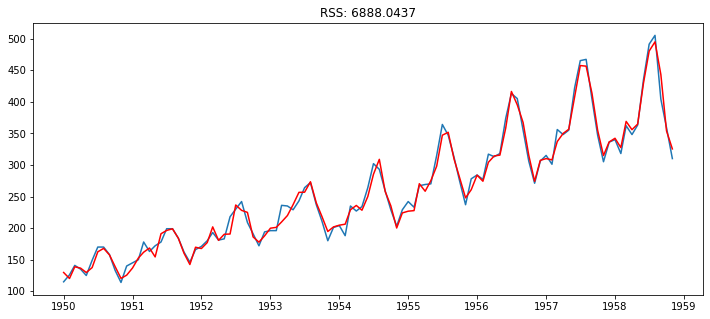

In [55]:
plt.figure(figsize=(12,5))
plt.plot(train.index[12:].to_pydatetime(), train.values[12:])
plt.plot(train.index[12:].to_pydatetime(), results_ARIMA.fittedvalues[12:], color='red')
plt.title('RSS: %.4f'% sum(results_ARIMA.fittedvalues[12:] - train.values[12:]) ** 2)
plt.plot()

#### Plot residual errors

                0
count  119.000000
mean     1.040578
std     15.453915
min    -50.008362
25%     -6.899703
50%     -0.285432
75%      7.379081
max    112.000000


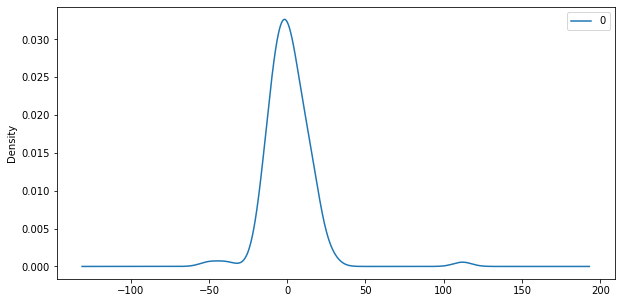

In [56]:
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde', figsize=(10,5))
print(residuals.describe())

### <font color=blue> 6. Perform and visualize test set

In [57]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results_ARIMA.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(12,2,2) Predictions')

In [58]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]}, expected={test[i]}")

predicted=341.1147431330102, expected=337
predicted=346.92951816833437, expected=360
predicted=326.1318178548929, expected=342
predicted=369.96888200544197, expected=406
predicted=355.2267846533251, expected=396
predicted=379.99461138719795, expected=420
predicted=448.280525666891, expected=472
predicted=507.5692967589864, expected=548
predicted=520.0992836658045, expected=559
predicted=427.6604716266836, expected=463
predicted=384.9229588058263, expected=407
predicted=341.62387476021166, expected=362
predicted=369.79571256981365, expected=405
predicted=372.45289726066, expected=417
predicted=350.90444177294216, expected=391
predicted=390.6984597939219, expected=419
predicted=374.6612419486135, expected=461
predicted=405.1206808666034, expected=472
predicted=469.43799191288684, expected=535
predicted=529.6042750271287, expected=622
predicted=540.5772161513374, expected=606
predicted=454.77308909611884, expected=508
predicted=414.56463451938646, expected=461
predicted=375.2758811108086,

[]

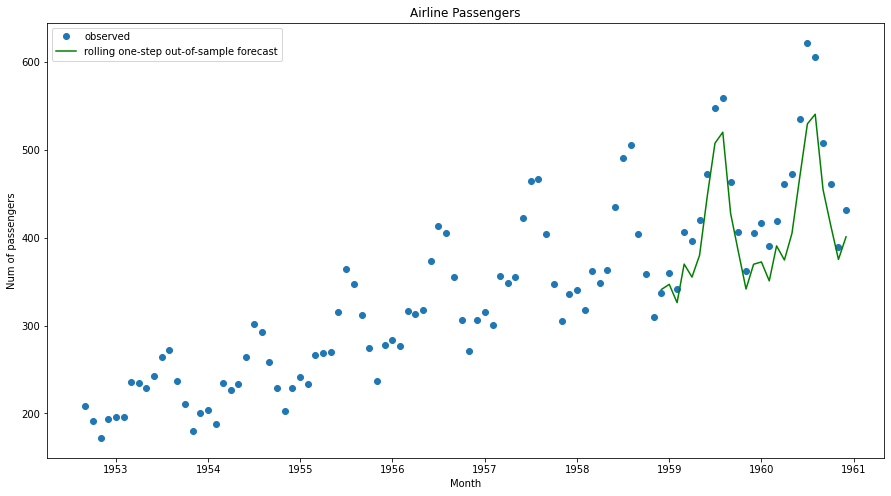

In [59]:
# visualize time series forecast
predictions_series = pd.Series(predictions, index = test.index)
fig, ax = plt.subplots(figsize=(15,8))
ax.set(title='Airline Passengers', xlabel='Month', ylabel='Num of passengers')
ax.plot(ts_data[-100:], 'o', label='observed')
ax.plot(predictions_series, 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
plt.plot()

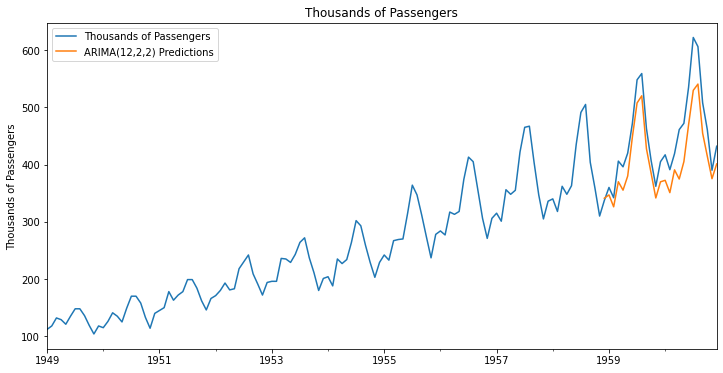

In [60]:
# HERE'S A TRICK TO ADD COMMAS TO Y-AXIS TICK VALUES
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

# Plot predictions against known values
title = 'Thousands of Passengers'
ylabel='Thousands of Passengers'
xlabel='' # we don't really need a label here

ax = df['Thousands of Passengers'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### <font color=blue>7. Evaluate the Model

In [61]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test, predictions)
print(f'ARIMA(12,2,2) MSE Error: {error:11.10}')

ARIMA(12,2,2) MSE Error: 2068.212391


In [62]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test, predictions)
print(f'ARIMA(12,2,2) RMSE Error: {error:11.10}')

ARIMA(12,2,2) RMSE Error: 45.47760318


### <font color=blue>8. Continously retrain model

In [63]:
historical = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = sm.tsa.ARIMA(historical, order=(12,2,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    observed = test[t]
    historical.append(observed)
    print('Predicted value = %f, Expected value = %f' % (yhat, observed))

Printing Predicted vs Expected Values...


Predicted value = 341.114743, Expected value = 337.000000
Predicted value = 346.044577, Expected value = 360.000000
Predicted value = 337.538997, Expected value = 342.000000
Predicted value = 383.435504, Expected value = 406.000000
Predicted value = 386.569174, Expected value = 396.000000
Predicted value = 410.740729, Expected value = 420.000000
Predicted value = 484.310139, Expected value = 472.000000
Predicted value = 523.301954, Expected value = 548.000000
Predicted value = 556.176181, Expected value = 559.000000
Predicted value = 458.373641, Expected value = 463.000000
Predicted value = 415.081675, Expected value = 407.000000
Predicted value = 353.450851, Expected value = 362.000000
Predicted value = 388.698271, Expected value = 405.000000
Predicted value = 416.513546, Expected value = 417.000000
Predicted value = 399.588737, Expected value = 391.000000
Predicted value = 443.132294, Expected value = 419.000000
Predicted value = 414.570873,

300.77026534345526


[]

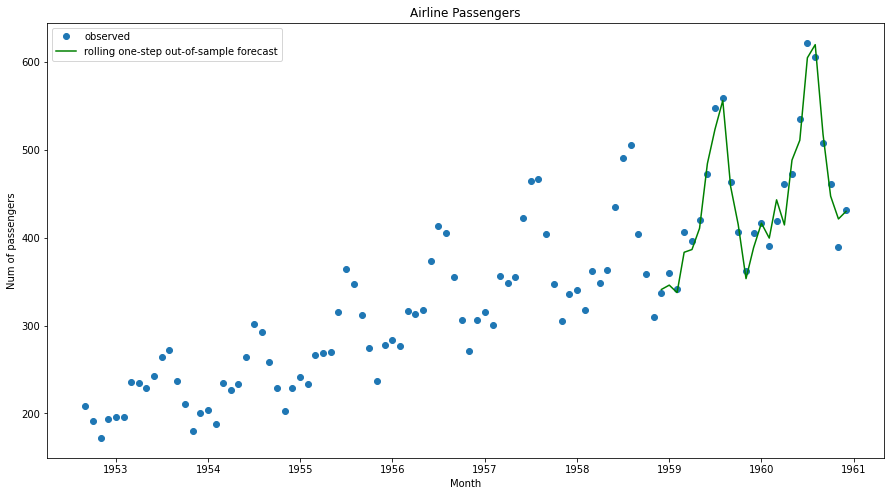

In [64]:
# calculate error
from sklearn.metrics import mean_squared_error    
error = mean_squared_error(test, predictions)
print(error)

# visualize time series forecast
predictions_series = pd.Series(predictions, index = test.index)
fig, ax = plt.subplots(figsize=(15,8))
ax.set(title='Airline Passengers', xlabel='Month', ylabel='Num of passengers')
ax.plot(ts_data[-100:], 'o', label='observed')
ax.plot(predictions_series, 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
plt.plot()

In [65]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test, predictions_series)
print(f'ARIMA(12,2,1) MSE Error: {error:11.10}')

ARIMA(12,2,1) MSE Error: 300.7702653


In [66]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test, predictions_series)
print(f'ARIMA(12,2,1) RMSE Error: {error:11.10}')

ARIMA(12,2,1) RMSE Error: 17.34272947


### <font color=blue>9. Retrain the model on the full data, and forecast the future

In [67]:
model = sm.tsa.ARIMA(ts_data,order=(12,2,2))
results = model.fit()
fcast = results.predict(len(ts_data),len(ts_data)+11,typ='levels').rename('ARIMA(12,2,2) Forecast')

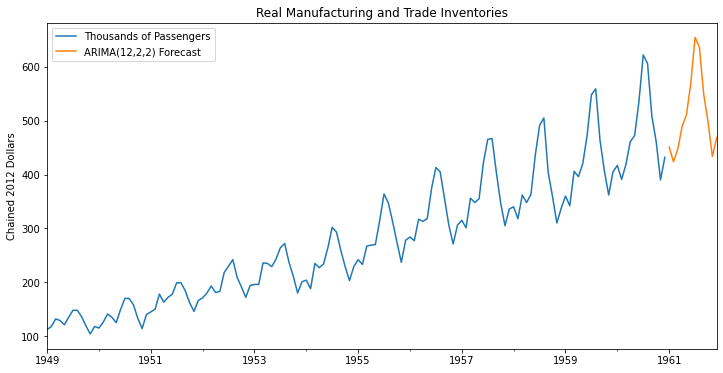

In [68]:
#### Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = ts_data.plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

## <font color=red> 8.2. SARIMA

### <font color=blue>1. Chosing ARIMA Orders

#### Using auto arima

In [69]:
from pmdarima import auto_arima
auto_arima(train,seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  119
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -535.824
Date:                Sat, 12 Apr 2025   AIC                           1081.648
Time:                        17:11:21   BIC                           1095.502
Sample:                             0   HQIC                          1087.273
                                - 119                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6715      0.032     52.211      0.000       1.609       1.734
ar.L2         -0.9312      0.030    -31.108      0.000      -0.990      -0.873
ma.L1         -1.8497      0.044    -42.371      0.000      -1.935      -1.764
ma.L2          0.9603      0.046     20.988      0.000       0.871       1.050
sigma2       492.5354     62.447      7.887      0.000     370.141     614.929
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.50   Prob(JB):                         0.93
Heteroskedasticity (H):               5.77   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [70]:
from pmdarima import auto_arima
# For SARIMA orders, we set seasonal=True and pass in a m value
auto_arima(train, seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  119
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -396.839
Date:                            Sat, 12 Apr 2025   AIC                            801.679
Time:                                    17:11:48   BIC                            812.370
Sample:                                         0   HQIC                           806.013
                                            - 119                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.5597      2.054      2.220      0.026       0.533       8.586
ar.L1          0.6701      0.100      6.694      0.000       0.474       0.866
ar.L2          0.1562      0.097      1.614      0.106      -0.033       0.346
sigma2        96.5155     11.915      8.101      0.000      73.163     119.868
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.62
Prob(Q):                              0.92   Prob(JB):                         0.45
Heteroskedasticity (H):               1.47   Skew:                             0.00
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### ARMA_Order_Select_IC
Statsmodels has a selection tool to find orders for ARMA models on stationary data.

In [71]:
from statsmodels.tsa.stattools import arma_order_select_ic

In [72]:
help(arma_order_select_ic)

Help on function arma_order_select_ic in module statsmodels.tsa.stattools:

arma_order_select_ic(y, max_ar=4, max_ma=2, ic='bic', trend='c', model_kw=None, fit_kw=None)
    Compute information criteria for many ARMA models.
    
    Parameters
    ----------
    y : array_like
        Array of time-series data.
    max_ar : int
        Maximum number of AR lags to use. Default 4.
    max_ma : int
        Maximum number of MA lags to use. Default 2.
    ic : str, list
        Information criteria to report. Either a single string or a list
        of different criteria is possible.
    trend : str
        The trend to use when fitting the ARMA models.
    model_kw : dict
        Keyword arguments to be passed to the ``ARMA`` model.
    fit_kw : dict
        Keyword arguments to be passed to ``ARMA.fit``.
    
    Returns
    -------
    Bunch
        Dict-like object with attribute access. Each ic is an attribute with a
        DataFrame for the results. The AR order used is the row ind

In [73]:
arma_order_select_ic(train)

{'bic':              0            1            2
 0  1430.011280  1290.055652  1231.201678
 1  1151.075567  1137.894812  1141.239950
 2  1141.593989  1138.489417  1141.487056
 3  1143.072671  1141.161844  1145.921887
 4  1147.236742  1145.867303  1139.969564,
 'bic_min_order': (1, 1)}

### <font color=blue>2. Train SARIMA

In [74]:
# We have seasonal data!
model = sm.tsa.statespace.SARIMAX(train,order=(0,1,1), seasonal_order=(2,1,0,12))
results = model.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:             Thousands of Passengers   No. Observations:                  119
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -395.376
Date:                             Sat, 12 Apr 2025   AIC                            798.752
Time:                                     17:11:56   BIC                            809.406
Sample:                                 01-01-1949   HQIC                           803.070
                                      - 11-01-1958                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2782      0.082     -3.391      0.001      -0.439      -0.117
ar.S.L12      -0.0370      

### <font color=blue> 3. Prediction of Future Values

Firts we can get an idea of how well our model performs by just predicting for values that we actually already know:

In [75]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')

In [76]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]}, expected={test[i]}")

predicted=341.9912039666562, expected=337
predicted=346.63187312333037, expected=360
predicted=323.8637205731295, expected=342
predicted=370.5497244879303, expected=406
predicted=356.1635701601186, expected=396
predicted=371.1718823709637, expected=420
predicted=444.6587661644855, expected=472
predicted=500.7862495580122, expected=548
predicted=515.8624943493778, expected=559
predicted=414.29112311031446, expected=463
predicted=367.6319426799996, expected=407
predicted=317.82683713918664, expected=362
predicted=349.17354088348367, expected=405
predicted=353.03069505947, expected=417
predicted=329.0751835002763, expected=391
predicted=373.9902827910467, expected=419
predicted=358.7065896132586, expected=461
predicted=374.9303392060235, expected=472
predicted=449.1221185360377, expected=535
predicted=507.2204759192451, expected=622
predicted=524.0805670613928, expected=606
predicted=416.7555231192591, expected=508
predicted=371.9812711822633, expected=461
predicted=321.14214022384374, ex

[]

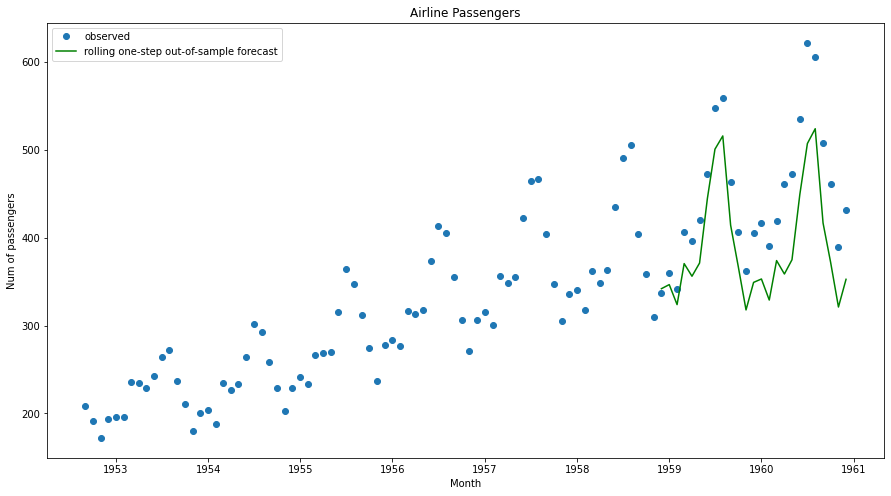

In [77]:
# visualize time series forecast
predictions_series = pd.Series(predictions, index = test.index)
fig, ax = plt.subplots(figsize=(15,8))
ax.set(title='Airline Passengers', xlabel='Month', ylabel='Num of passengers')
ax.plot(ts_data[-100:], 'o', label='observed')
ax.plot(predictions_series, 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
plt.plot()

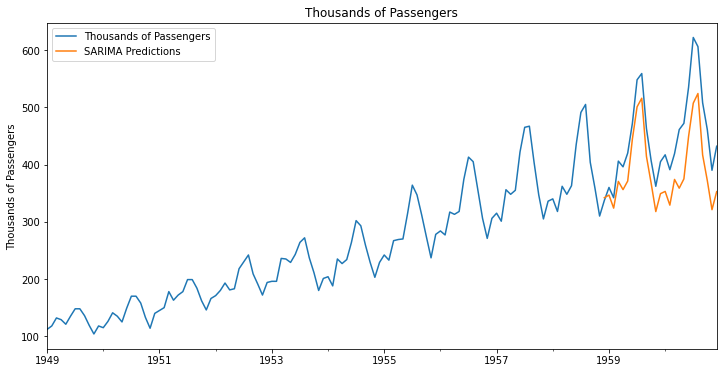

In [78]:
# HERE'S A TRICK TO ADD COMMAS TO Y-AXIS TICK VALUES
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

# Plot predictions against known values
title = 'Thousands of Passengers'
ylabel='Thousands of Passengers'
xlabel='' # we don't really need a label here

ax = ts_data.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### <font color=blue> 4. Evaluate the Model

In [79]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test, predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) MSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) MSE Error: 4158.920733


In [80]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test, predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) RMSE Error: 64.48969478


### <font color=blue>5. Retrain the model on the full data, and forecast the future

In [81]:
model = sm.tsa.statespace.SARIMAX(ts_data,order=(1,1,0), seasonal_order=(0,1,0,12))
results = model.fit()
fcast = results.predict(len(ts_data),len(ts_data)+11,typ='levels').rename('SARIMA Forecast')

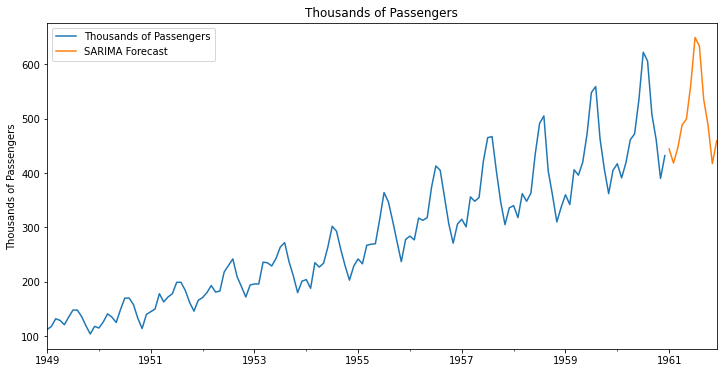

In [82]:
# Plot predictions against known values
title = 'Thousands of Passengers'
ylabel='Thousands of Passengers'
xlabel=''

ax = ts_data.plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## <font color=red> 8.3. ARIMA with second order differencing

### <font color=blue> 1. Calculate second order differencing

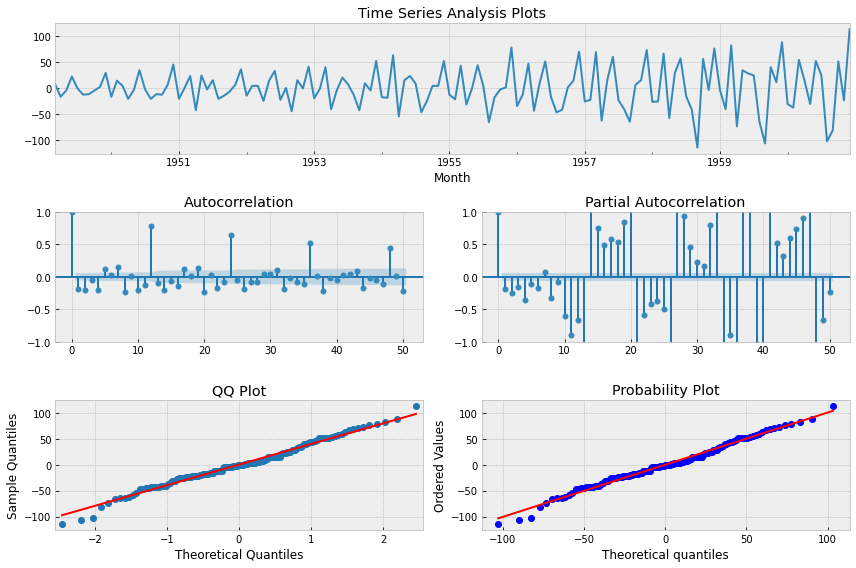

In [83]:
ts_data = df['Thousands of Passengers'].diff().diff()
#ts_data.dropna(inplace=True)

tsplot(ts_data.dropna(), lags=50)

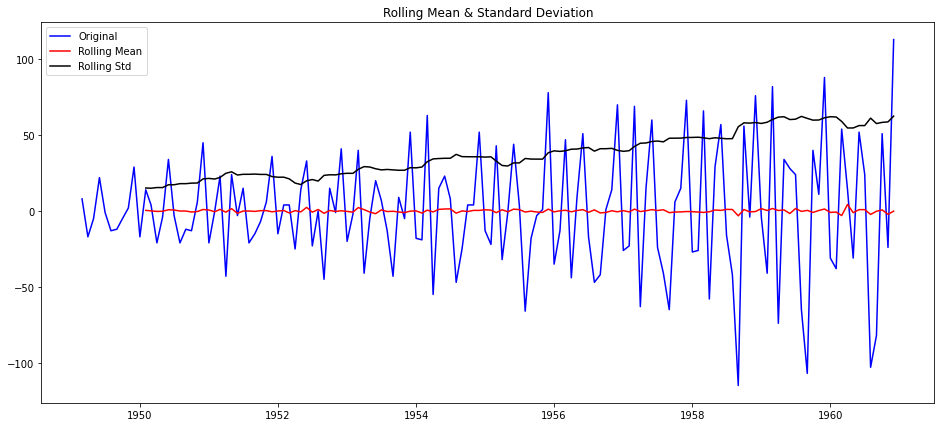

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.638423e+01
p-value                 2.732892e-29
# lags used             1.100000e+01
# observations          1.300000e+02
critical value (1%)    -3.481682e+00
critical value (5%)    -2.884042e+00
critical value (10%)   -2.578770e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [84]:
check_stationarity(ts_data.dropna(), 12)

### <font color=blue> 2. Split time series data

In [85]:
# split data into 2 sets: train set and test set
size = int(len(ts_data) - 25)
train, test = ts_data[0:size], ts_data[size:len(ts_data.values)]
size

119

### <font color=blue> 3. Train the model

In [86]:
#model = sm.tsa.ARIMA(train, order=(12,1,1))
model = sm.tsa.statespace.SARIMAX(train,order=(1,0,1), seasonal_order=(0,1,0,12))
results_ARIMA = model.fit()

### <font color=blue>4. Print the results of the ARIMA model

In [87]:
print(results_ARIMA.summary())

                                      SARIMAX Results                                      
Dep. Variable:             Thousands of Passengers   No. Observations:                  119
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 12)   Log Likelihood                -411.205
Date:                             Sat, 12 Apr 2025   AIC                            828.411
Time:                                     17:12:07   BIC                            836.429
Sample:                                 01-01-1949   HQIC                           831.661
                                      - 11-01-1958                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2359      0.094     -2.513      0.012      -0.420      -0.052
ma.L1         -0.9996      

### <font color=blue> 5. Plot results

[]

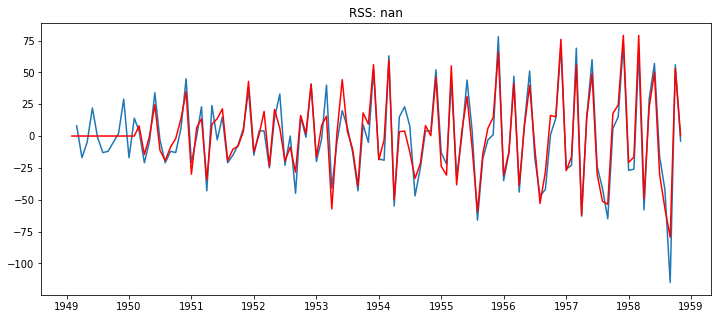

In [88]:
plt.figure(figsize=(12,5))
plt.plot(train.index[1:].to_pydatetime(), train.values[1:])
plt.plot(train.index[1:].to_pydatetime(), results_ARIMA.fittedvalues[1:], color='red')
plt.title('RSS: %.4f'% sum(results_ARIMA.fittedvalues[1:] - train.values[1:]) ** 2)
plt.plot()

#### Plot residual errors

                0
count  117.000000
mean    -0.814761
std     10.884959
min    -35.552007
25%     -6.939887
50%     -2.976509
75%      6.620351
max     29.000449


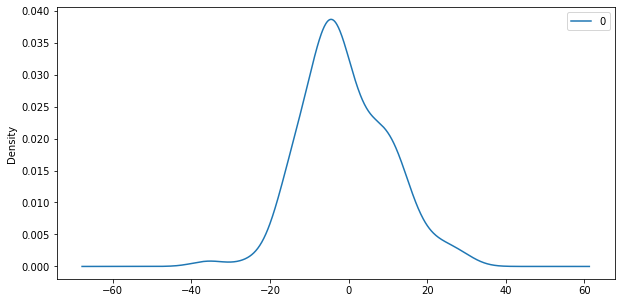

In [89]:
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde', figsize=(10,5))
print(residuals.describe())

### <font color=blue> 6. Perform and visualize test set

In [90]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results_ARIMA.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,0,1) Predictions')
predictions.head()

1958-12-01    81.678625
1959-01-01   -29.046961
1959-02-01   -25.517199
1959-03-01    65.886125
1959-04-01   -57.973141
Freq: MS, Name: ARIMA(1,0,1) Predictions, dtype: float64

[]

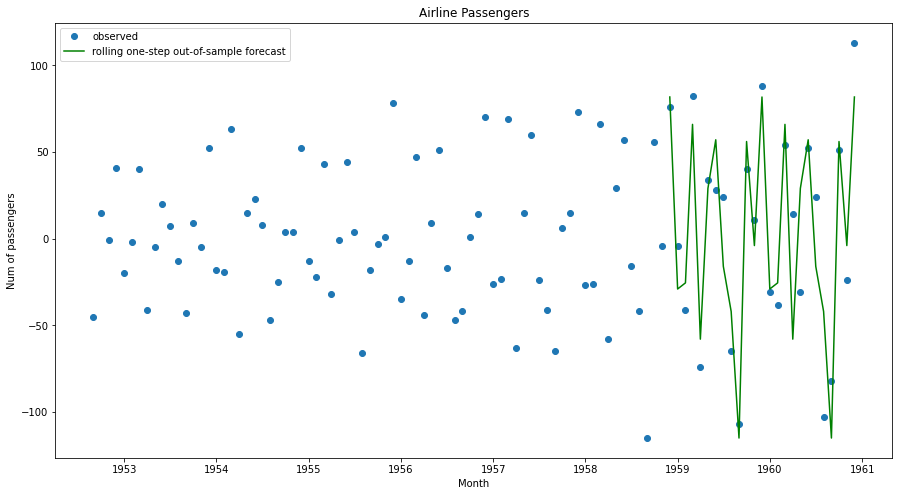

In [91]:
# visualize time series forecast
predictions_series = pd.Series(predictions, index = test.index)
fig, ax = plt.subplots(figsize=(15,8))
ax.set(title='Airline Passengers', xlabel='Month', ylabel='Num of passengers')
ax.plot(ts_data[-100:], 'o', label='observed')
ax.plot(predictions_series, 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
plt.plot()

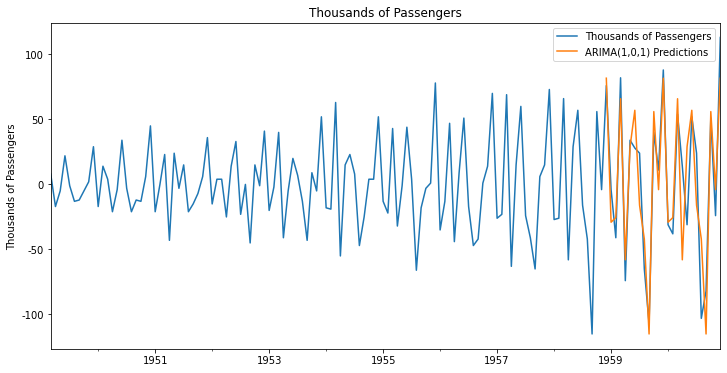

In [92]:
# HERE'S A TRICK TO ADD COMMAS TO Y-AXIS TICK VALUES
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

# Plot predictions against known values
title = 'Thousands of Passengers'
ylabel='Thousands of Passengers'
xlabel='' # we don't really need a label here

ax = ts_data.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [93]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]}, expected={test[i]}")

predicted=81.67862467933558, expected=76.0
predicted=-29.046960756500486, expected=-4.0
predicted=-25.517199038618433, expected=-41.0
predicted=65.88612543373354, expected=82.0
predicted=-57.97314127791861, expected=-74.0
predicted=28.99366503886252, expected=34.0
predicted=57.001494178780796, expected=28.0
predicted=-16.000352420509063, expected=24.0
predicted=-41.99991687727278, expected=-65.0
predicted=-115.00001960552125, expected=-107.0
predicted=56.00000462420419, expected=40.0
predicted=-4.000001090675638, expected=11.0
predicted=81.6786249365849, expected=88.0
predicted=-29.04696081717591, expected=-31.0
predicted=-25.517199024307384, expected=-38.0
predicted=65.8861254303581, expected=54.0
predicted=-57.973141277122465, expected=14.0
predicted=28.99366503867474, expected=-31.0
predicted=57.001494178825084, expected=52.0
predicted=-16.00035242051951, expected=24.0
predicted=-41.999916877270316, expected=-103.0
predicted=-115.00001960552183, expected=-82.0
predicted=56.000004624

In [94]:
first_diff = (df['Thousands of Passengers'][size-1] - df['Thousands of Passengers'][size-2]) + predictions.cumsum()
converted_prediction = df['Thousands of Passengers'][size-1] + first_diff.cumsum()

In [95]:
forecast = []

# Capture the two most recent values from the training set
v2,v1 = df['Thousands of Passengers'][size-2],df['Thousands of Passengers'][size-1]

# Apply the formula
for i in predictions:
    newval = i + 2*v1 - v2
    forecast.append(newval)
    v2,v1 = v1,newval

In [96]:
df['prediction'] = converted_prediction
df[size:].head()

,Thousands of Passengers,prediction
Month,,
1958-12-01,337,342.678625
1959-01-01,360,346.310289
1959-02-01,342,324.424753
1959-03-01,406,368.425344
1959-04-01,396,354.452793


[]

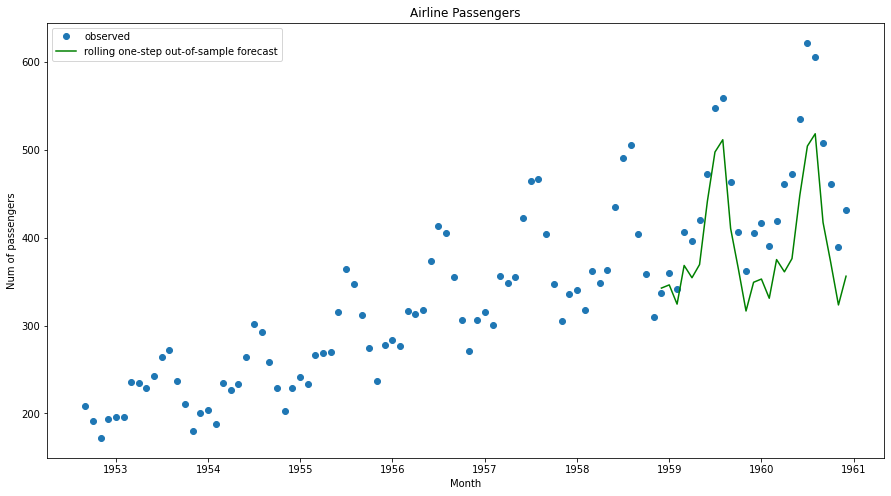

In [97]:
# visualize time series forecast
predictions_series = pd.Series(predictions, index = test.index)
fig, ax = plt.subplots(figsize=(15,8))
ax.set(title='Airline Passengers', xlabel='Month', ylabel='Num of passengers')
ax.plot(df['Thousands of Passengers'][-100:], 'o', label='observed')
ax.plot(converted_prediction, 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')
plt.plot()

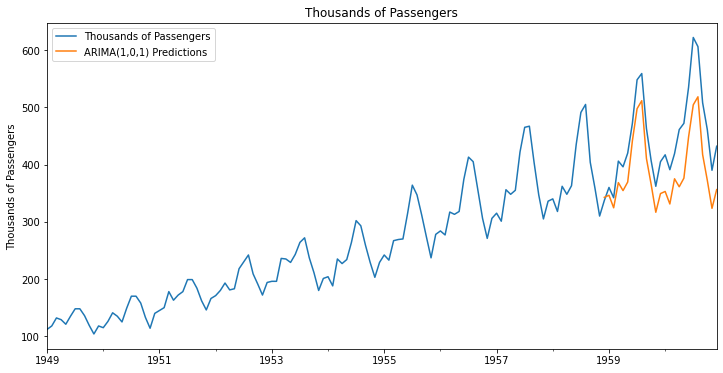

In [98]:
# HERE'S A TRICK TO ADD COMMAS TO Y-AXIS TICK VALUES
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

# Plot predictions against known values
title = 'Thousands of Passengers'
ylabel='Thousands of Passengers'
xlabel='' # we don't really need a label here

ax = df['Thousands of Passengers'].plot(legend=True,figsize=(12,6),title=title)
converted_prediction.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

### <font color=blue>7. Evaluate the Model

In [99]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test, predictions)
print(f'ARIMA(12,2,2) MSE Error: {error:11.10}')

ARIMA(12,2,2) MSE Error: 876.6937732


In [100]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(df['Thousands of Passengers'][size:].values, df['prediction'][size:].values)
print(f'ARIMA(12,2,2) MSE Error: {error:11.10}')

ARIMA(12,2,2) MSE Error: 4224.430967


In [101]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test, predictions)
print(f'ARIMA(12,2,2) RMSE Error: {error:11.10}')

ARIMA(12,2,2) RMSE Error: 29.60901507


In [102]:
from sklearn.metrics import mean_squared_error

error = rmse(df['Thousands of Passengers'][size:].values, df['prediction'][size:].values)
print(f'ARIMA(12,2,2) MSE Error: {error:11.10}')

ARIMA(12,2,2) MSE Error: 64.99562268


### <font color=blue>8. Retrain the model on the full data, and forecast the future

In [103]:
fcast = results_ARIMA.predict(len(ts_data),len(ts_data)+11,typ='levels').rename('ARIMA(12,0,1) Forecast')
first_diff = (df['Thousands of Passengers'][-1] - df['Thousands of Passengers'][-2]) + fcast.cumsum()
converted_fcast = df['Thousands of Passengers'][-1] + first_diff.cumsum()

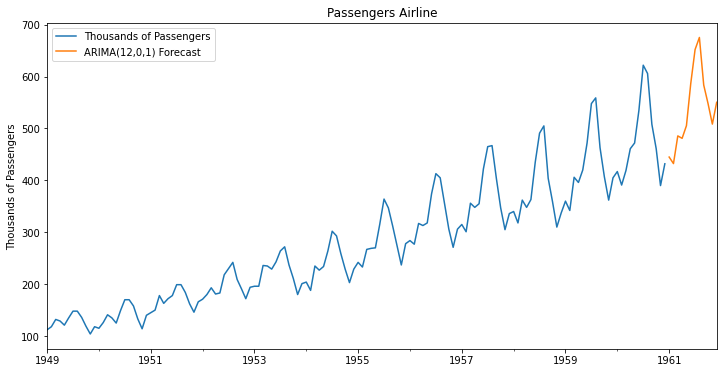

In [104]:
# Plot predictions against known values
title = 'Passengers Airline'
ylabel='Thousands of Passengers'
xlabel='' # we don't really need a label here

ax = df['Thousands of Passengers'].plot(legend=True,figsize=(12,6),title=title)
converted_fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);